In [1]:
import os
import pandas as pd
import numpy as np
import sklearn.metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import _gradient_boosting
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from helper_functions_pipe_testing import *
from sklearn.metrics import  f1_score, recall_score, precision_score, confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import *
from sklearn.preprocessing import LabelEncoder
from helper_functions_KP import *
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.linear_model import LogisticRegression
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score

In [5]:
# Large OG Pipeline # Move lower #

#Editable Variables
#list of test filters
zerosperrow = 0.3
multi_files = True  #set to false if you just want to set one  prot_abund_file
rfecv_ = True  #True_runs RFECV
rfe_ = False     #True runs Recursive feature elimination
abund_controls = True # True keeps the serum as an input feature
splits = 10     #number of splits for cross validation across QC methods and feature selection methods
in_dir = "Input_data/Proteomic data/Abundance2/"
prot_abund_file = 'Input_data/Proteomic data/Abundance2/Norm_Intensity _all20230403.xlsx'
NP_filepath = 'Input_data/NPs/NP_Database.xlsx'
controls_file = 'Input_data/Proteomic data/controls_combined.xlsx'
uniprot_filepath = 'Input_data/BioPython_data/Combined_biopyCalcs.xlsx'
NSPfilePath = 'Input_data/NetSurfP_data/Combined.xlsx'

scorings=['r2','neg_mean_squared_error','mean_absolute_error']
RFE_Feats = 40
model = RandomForestRegressor(n_estimators=80)
# model=XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, objective='reg:squarederror')
summary_tmp=[]
for z in scorings:
    id = 'Con_drop_' +str(z)+ '_30' + '%zeros'
    # take files in_dir and combine then into a pandas df (raw_MS_data) ###USE when combining multiple datasets####
    # melt the df to make it an accession number, NPUNID, Abundance dataset before combining
    files = os.listdir(in_dir)
    if multi_files == True:
        for i, f in enumerate(files):
            if i == 0:
                raw_MS_data = pd.read_excel(in_dir + f, header=0)
                cols = raw_MS_data.shape[1]
                cutoff = int(zerosperrow * cols)
                print('shape before dropping rows', raw_MS_data.shape)
                raw_MS_data = raw_MS_data.drop(raw_MS_data[(raw_MS_data == 0).sum(axis=1) >= cutoff].index)
                print('shape after dropping rows', raw_MS_data.shape)
                # print(raw_MS_data)
                raw_MS_data = pd.melt(raw_MS_data, id_vars=['Entry'], var_name='Sample_num', value_name='Abundance')

            else:

                temp = pd.read_excel(in_dir + f, header=0)
                cols = temp.shape[1]
                cutoff = int(zerosperrow * cols)
                print('shape before dropping rows', raw_MS_data.shape)
                temp = temp.drop(temp[(temp == 0).sum(axis=1) >= cutoff].index)
                print('shape after dropping rows', raw_MS_data.shape)
                temp = pd.melt(temp, id_vars=['Entry'], var_name='Sample_num', value_name='Abundance')

                raw_MS_data = pd.concat([raw_MS_data, temp])
                print('final shape after melt', raw_MS_data.shape)
                print('number of zeros in the dataset:',(raw_MS_data == 0).sum().sum())


    else:
        raw_MS_data = pd.read_excel(prot_abund_file, header=0)
        cols = raw_MS_data.shape[1]
        cutoff = int(zerosperrow * cols)
        print('shape beofre dropping rows', raw_MS_data.shape)
        raw_MS_data = raw_MS_data.drop(raw_MS_data[(raw_MS_data == 0).sum(axis=1) >= cutoff].index)
        print('shape after dropping rows', raw_MS_data.shape)
        raw_MS_data = pd.melt(raw_MS_data, id_vars=['Entry'], var_name='Sample_num', value_name='Abundance')
    #remove prots that were added due to merge
    raw_MS_data = raw_MS_data.dropna()
    ###Bring in controls (MS data for serums)##
    controls = pd.read_excel(controls_file, header=0)
    MS_data_controls = pd.merge(raw_MS_data, controls, how='left', on='Entry')
    ###Bring in Uniprot_data,NSPdata and NP data##
    uniprot_dat = pd.read_excel(uniprot_filepath, header=0)
    NSP_data = pd.read_excel(NSPfilePath)
    ###Bring in NP data and merge to get complete NP dataset###
    NPUNdata = pd.read_excel(NP_filepath, header=0, sheet_name='NPUNID')
    NPprop = pd.read_excel(NP_filepath, header=0, sheet_name='NP_Props')
    NPdata = pd.merge(NPUNdata, NPprop, how="left", on='NPID')
    NPdata.dropna(inplace=True)
    #calculate Enrichment
    #####MAYBE add binning here to keep negative results and improve capapbilities######
    # MS_data_controls['Enrichment']= np.log2(MS_data_controls['Abundance']/MS_data_controls['Abundance_Controls'])
    # MS_data=MS_data_controls.drop(columns=['Abundance','Abundance_Controls'])
    raw_prop_data = pd.merge(MS_data_controls, uniprot_dat.drop_duplicates(subset=['Entry']), how='left', on='Entry')
    Protein_data_complete = pd.merge(raw_prop_data, NSP_data.drop_duplicates(subset=['Entry']), how='left',
                                     on='Entry')
    #merges netsurfp features and biopython features
    Protein_data_complete.fillna(0, inplace=True)
    data_complete = pd.merge(Protein_data_complete, NPdata, how='inner', on='Sample_num')
    data_complete.fillna(0, inplace=True)
    #create ordinal variables for the core materials and surface ligands
    le = LabelEncoder()
    data_complete['Core Material'] = le.fit_transform(data_complete['Core Material'])
    data_complete['Surface_Ligand'] = le.fit_transform(data_complete['Surface_Ligand'])
    #shuffle data using sample
    data_complete = data_complete.sample(frac=1)
    #set labels (what we are trying to predict) as Abundance
    label_abund_df = data_complete['Abundance'].copy()
    label_abund = np.ravel(label_abund_df)
    NPIDs=data_complete['NPUNID'].copy()
    data_complete.drop(columns=['notes', 'Notes', 'NPUNID'], inplace=True)

    #make it one dimenisional
    #drop qualitative, not neccessary, and label columns
    #create df without bonus NSP columns (remove total_exposed) There are too sets of features total_exposed and exposed_exposed
    to_drop = data_complete.filter(like='total_exposed_')
    data_complete.drop(columns=to_drop, inplace=True)
    df = data_complete.drop(
        ['Entry', 'Abundance', 'Sequence', 'NPID', 'Ligands', 'Protein Source', 'Sample_num', 'Unnamed: 5',
         'Raw_FileID'], axis=1)
    if abund_controls == False:
        df.drop(columns=['Abundance_Controls'], inplace=True)

    df_out=pd.concat([df, NPIDs,label_abund_df],axis=1)
    df_out.to_excel("Input_data/Save_files/df_whole_"+id+".xlsx")

shape before dropping rows (474, 14)
shape after dropping rows (27, 14)
shape before dropping rows (351, 3)
shape after dropping rows (351, 3)
final shape after melt (6841, 3)
number of zeros in the dataset: 752
shape before dropping rows (474, 14)
shape after dropping rows (27, 14)
shape before dropping rows (351, 3)
shape after dropping rows (351, 3)
final shape after melt (6841, 3)
number of zeros in the dataset: 752


KeyboardInterrupt: 

#Instructions for the pipeline Requires two inputs for training: - Mass spec data with corresponding NP surface characteristics and experimental conditions (time, concentration) - NetsurfP and Biopython data that has been precalculated - X characteristics to predict
pipeline Take mass spec spreadsheet Accession,Enrichment,Dh,TEM,Zp,BET,Composition,Ligand,Shape,IncubationTime,IncubationConcentration Merge with Proteome data to get file that has Accession,Enrichment,Dh,TEM,Zp,BET,Composition,Ligand,Shape,IncubationTime,IncubationConcentration,Mass,Length,Sequence Calculate protein features using biopython Merge with NSP data to get all protein features
Split into X and Y dataset with Entries as labels

In [ ]:
# Large OG Pipeline # Move lower #

#Editable Variables
#list of test filters
zerosperrow = 0.3
multi_files = True  #set to false if you just want to set one  prot_abund_file
rfecv_ = True  #True_runs RFECV
rfe_ = False     #True runs Recursive feature elimination
abund_controls = True # True keeps the serum as an input feature
splits = 10     #number of splits for cross validation across QC methods and feature selection methods
in_dir = "Input_data/Proteomic data/Abundance2/"
prot_abund_file = 'Input_data/Proteomic data/Abundance2/Norm_Intensity _all20230403.xlsx'
NP_filepath = 'Input_data/NPs/NP_Database.xlsx'
controls_file = 'Input_data/Proteomic data/controls_combined.xlsx'
uniprot_filepath = 'Input_data/BioPython_data/Combined_biopyCalcs.xlsx'
NSPfilePath = 'Input_data/NetSurfP_data/Combined.xlsx'

scorings=['r2','neg_mean_squared_error','mean_absolute_error']
RFE_Feats = 40
model = RandomForestRegressor(n_estimators=80)
# model=XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, objective='reg:squarederror')
summary_tmp=[]
for z in scorings:
    id = 'Con_drop_' +str(z)+ '_30' + '%zeros'
    # take files in_dir and combine then into a pandas df (raw_MS_data) ###USE when combining multiple datasets####
    # melt the df to make it an accession number, NPUNID, Abundance dataset before combining
    files = os.listdir(in_dir)
    if multi_files == True:
        for i, f in enumerate(files):
            if i == 0:
                raw_MS_data = pd.read_excel(in_dir + f, header=0)
                cols = raw_MS_data.shape[1]
                cutoff = int(zerosperrow * cols)
                print('shape before dropping rows', raw_MS_data.shape)
                raw_MS_data = raw_MS_data.drop(raw_MS_data[(raw_MS_data == 0).sum(axis=1) >= cutoff].index)
                print('shape after dropping rows', raw_MS_data.shape)
                # print(raw_MS_data)
                raw_MS_data = pd.melt(raw_MS_data, id_vars=['Entry'], var_name='Sample_num', value_name='Abundance')

            else:

                temp = pd.read_excel(in_dir + f, header=0)
                cols = temp.shape[1]
                cutoff = int(zerosperrow * cols)
                print('shape before dropping rows', raw_MS_data.shape)
                temp = temp.drop(temp[(temp == 0).sum(axis=1) >= cutoff].index)
                print('shape after dropping rows', raw_MS_data.shape)
                temp = pd.melt(temp, id_vars=['Entry'], var_name='Sample_num', value_name='Abundance')

                raw_MS_data = pd.concat([raw_MS_data, temp])
                print('final shape after melt', raw_MS_data.shape)
                print('number of zeros in the dataset:',(raw_MS_data == 0).sum().sum())


    else:
        raw_MS_data = pd.read_excel(prot_abund_file, header=0)
        cols = raw_MS_data.shape[1]
        cutoff = int(zerosperrow * cols)
        print('shape beofre dropping rows', raw_MS_data.shape)
        raw_MS_data = raw_MS_data.drop(raw_MS_data[(raw_MS_data == 0).sum(axis=1) >= cutoff].index)
        print('shape after dropping rows', raw_MS_data.shape)
        raw_MS_data = pd.melt(raw_MS_data, id_vars=['Entry'], var_name='Sample_num', value_name='Abundance')
    #remove prots that were added due to merge
    raw_MS_data = raw_MS_data.dropna()
    ###Bring in controls (MS data for serums)##
    controls = pd.read_excel(controls_file, header=0)
    MS_data_controls = pd.merge(raw_MS_data, controls, how='left', on='Entry')
    ###Bring in Uniprot_data,NSPdata and NP data##
    uniprot_dat = pd.read_excel(uniprot_filepath, header=0)
    NSP_data = pd.read_excel(NSPfilePath)
    ###Bring in NP data and merge to get complete NP dataset###
    NPUNdata = pd.read_excel(NP_filepath, header=0, sheet_name='NPUNID')
    NPprop = pd.read_excel(NP_filepath, header=0, sheet_name='NP_Props')
    NPdata = pd.merge(NPUNdata, NPprop, how="left", on='NPID')
    NPdata.dropna(inplace=True)
    #calculate Enrichment
    #####MAYBE add binning here to keep negative results and improve capapbilities######
    # MS_data_controls['Enrichment']= np.log2(MS_data_controls['Abundance']/MS_data_controls['Abundance_Controls'])
    # MS_data=MS_data_controls.drop(columns=['Abundance','Abundance_Controls'])
    raw_prop_data = pd.merge(MS_data_controls, uniprot_dat.drop_duplicates(subset=['Entry']), how='left', on='Entry')
    Protein_data_complete = pd.merge(raw_prop_data, NSP_data.drop_duplicates(subset=['Entry']), how='left',
                                     on='Entry')
    #merges netsurfp features and biopython features
    Protein_data_complete.fillna(0, inplace=True)
    data_complete = pd.merge(Protein_data_complete, NPdata, how='inner', on='Sample_num')
    data_complete.fillna(0, inplace=True)
    #create ordinal variables for the core materials and surface ligands
    le = LabelEncoder()
    data_complete['Core Material'] = le.fit_transform(data_complete['Core Material'])
    data_complete['Surface_Ligand'] = le.fit_transform(data_complete['Surface_Ligand'])
    #shuffle data using sample
    data_complete = data_complete.sample(frac=1)
    #set labels (what we are trying to predict) as Abundance
    label_abund_df = data_complete['Abundance'].copy()
    label_abund = np.ravel(label_abund_df)
    NPIDs=data_complete['NPUNID'].copy()
    data_complete.drop(columns=['notes', 'Notes', 'NPUNID'], inplace=True)

    #make it one dimenisional
    #drop qualitative, not neccessary, and label columns
    #create df without bonus NSP columns (remove total_exposed) There are too sets of features total_exposed and exposed_exposed
    to_drop = data_complete.filter(like='total_exposed_')
    data_complete.drop(columns=to_drop, inplace=True)
    df = data_complete.drop(
        ['Entry', 'Abundance', 'Sequence', 'NPID', 'Ligands', 'Protein Source', 'Sample_num', 'Unnamed: 5',
         'Raw_FileID'], axis=1)
    if abund_controls == False:
        df.drop(columns=['Abundance_Controls'], inplace=True)

    df_out=pd.concat([df, NPIDs,label_abund_df],axis=1)
    df_out.to_excel("Input_data/Save_files/df_whole_"+id+".xlsx")
    # label_abund_df.to_excel("Input_data/Save_files/label_abund"+id+".xlsx",index=False)

    #Run PCA to seee how data differentiates#
    # PCA_plot(df,label_abund,id)
    #use recursive feature elimination with Random Forest Regression as the estimator to select top 45 important features
    if rfe_ == True:
        step = 2
        estimator = RandomForestRegressor(n_estimators=100)
        selector = RFE(estimator, n_features_to_select=RFE_Feats, step=step)
        selector = selector.fit(df, label_abund)
        selector.support_
        ranking = selector.ranking_
        feat_list = selector.get_feature_names_out()
        df = df[feat_list]
        df_out=pd.concat([df, NPIDs,label_abund_df],axis=1)
        df_out.to_excel("Input_data/Save_files/df_RFE40_"+id+".xlsx")

    #run Recursive feature elimination with cross validation
    if rfecv_ == True:
        df = RFECV_plot(df,label_abund,model,id,folds=splits,step=2,scoring=z)
        df_out=pd.concat([df, NPIDs,label_abund_df],axis=1)
        df_out.to_excel("Input_data/Save_files/df_RFECV(40)_"+id+".xlsx")
    #Quality control
    # scram_score(df, label_abund, model, id, 0.2)
    # feat_drop(df, label_abund, model, id, 0.2)
    # feat_drop_multifold(df, label_abund, model, id, 0.2, folds=splits)
    # tmp2=scorer(df, label_abund, model, id, 10)
    # zeros=(raw_MS_data['Abundance']==0).sum()
    # percent_zeros=zeros/raw_MS_data.shape[0]
    # tmp2['TotalZeros']=zeros
    # tmp2['Percent_zeros']=percent_zeros
    # summary_tmp.append(tmp2)
    # lasso_feature_selection(df, label_abund, id)
    # summary=pd.concat(summary_tmp,axis=0)
# summary.to_excel('Output_data/'+id+'.xlsx', index=False)
print('done')


In [ ]:
### Running Binary Classification systems

abund_thresh=np.arange(0.01,1.0,0.01).tolist()
df_filepath='Input_data/Save_files/df_whole_drop_30%zeros.xlsx'
df = pd.read_excel(df_filepath, header=0)
model=RandomForestClassifier()
# id='RFR_AFilter_'+str(i)+'NoCon'
# Create an empty pandas DataFrame to store the evaluation metrics
eval_df = pd.DataFrame(columns=['Abund Thresh', 'F1', 'AUROC', 'Accuracy', 'Precision', 'Recall'])

# Iterate through multiple iterations of model training and testing
for i in abund_thresh:
    df_a=df.copy()
    df_a['binary_target']= df_a['Abundance'].apply(lambda t: 1 if t>=i else 0)
    labels_df= df_a['binary_target'].copy()
    # id_col= df_a['NPUNID'].copy()
    label_binary=np.ravel(labels_df)
    df_a=df_a.drop(columns=['Abundance','NPUNID','binary_target']).copy()
    x_train, x_test, y_train, y_test = train_test_split(df, label_binary, test_size=0.2, random_state=42)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    f1 = f1_score(y_test, y_pred)
    auroc = roc_auc_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    # Append a new row to the eval_df DataFrame with the evaluation metrics for this iteration
    eval_df = eval_df.append({'Abund Thresh': i,
                              'F1': f1,
                              'AUROC': auroc,
                              'Accuracy': accuracy,
                              'Precision': precision,
                              'Recall': recall}, ignore_index=True)

eval_df.to_excel('Output_data/AbundThresholdingRFC.xlsx', index=False)



In [ ]:
###Filtering Abundance to see if i stick to higher abundance I get better performance##
rfecv_ = False  #True_runs RFECV
rfe_ = True     #True runs Recursive feature elimination
abund_controls = False # True keeps the serum as an input feature
splits = 10     #number of splits for cross validation across QC methods and feature selection methods
df_filepath = 'Input_data/Save_files/df_whole_drop_30%zeros.xlsx'
df_a = pd.read_excel(df_filepath, header=0)
# scorings=['r2','neg_mean_squared_error','neg_mean_absolute_error']
RFE_Feats = 12
Abund_filter = np.arange(0.0001,0.1001,0.001).tolist()
model = RandomForestRegressor(n_estimators=80)
summary_tmp=[]
for i in Abund_filter:
    df= df_a[df_a['Abundance']>=i]
    id='RFR_AFilter_'+str(i)+'NoCon'
    labels_df= df['Abundance'].copy()
    id_col= df['NPUNID'].copy()
    label_abund=np.ravel(labels_df)
    df.drop(columns=['Abundance','NPUNID'],inplace=True)
    if abund_controls == False:
        df.drop(columns=['Abundance_Controls'], inplace=True)
    #run Recursive feature elimination with cross validation
    if rfecv_ == True:
        df = RFECV_plot(df,label_abund,model,id,folds=splits,step=2,scoring=z)
        # df_out=pd.concat([df, NPIDs,label_abund_df],axis=1)
        # df_out.to_excel("Input_data/Save_files/df_RFECV(40)_"+id+".xlsx")
    #Run Recursive feature elimination to remove down to RFE_Feats
    if rfe_ == True:
        step = 2
        selector = RFE(model, n_features_to_select=RFE_Feats, step=step)
        selector = selector.fit(df, label_abund)
        selector.support_
        ranking = selector.ranking_
        feat_list = selector.get_feature_names_out()
        df = df[feat_list]
        # df_out=pd.concat([df, NPIDs,label_abund_df],axis=1)
        # df_out.to_excel("Input_data/Save_files/df_RFE40_"+id+".xlsx")
    tmp2=scorer(df, label_abund, model, id, 10)
    tmp2['Abundance Filter']=i

    summary_tmp.append(tmp2)

    summary=pd.concat(summary_tmp,axis=0)
summary.to_excel('Output_data/'+id+'.xlsx', index=False)


In [ ]:
df_a = pd.read_excel(df_filepath, header=0)
# df=df_a[df_a['Abundance']>=0.01]
# df_a['Abundance']=np.log10(df_a['Abundance']+1)
df['Abundance']=np.log2(df['Abundance']+1)
plt.hist(df['Abundance'],bins=25)
plt.xlim(-2,2)
plt.show()

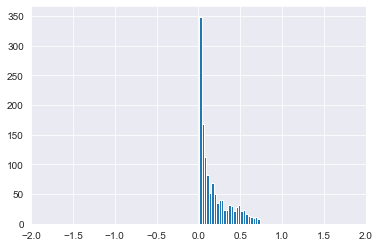

In [24]:
df_a = pd.read_excel(df_filepath, header=0)
# df=df_a[df_a['Abundance']>=0.01]
# df_a['Abundance']=np.log10(df_a['Abundance']+1)
df['Abundance']=np.log2(df['Abundance']+1)
plt.hist(df['Abundance'],bins=25)
plt.xlim(-2,2)
plt.show()

In [ ]:
#Editable Variables
#list of test filters
zerosperrow = 0.3
multi_files = True  #set to false if you just want to set one  prot_abund_file
rfecv_ = True  #True_runs RFECV
rfe_ = False     #True runs Recursive feature elimination
abund_controls = True # True keeps the serum as an input feature
splits = 10     #number of splits for cross validation across QC methods and feature selection methods
in_dir = "Input_data/Proteomic data/Abundance2/"
prot_abund_file = 'Input_data/Proteomic data/Abundance2/Norm_Intensity _all20230403.xlsx'
NP_filepath = 'Input_data/NPs/NP_Database.xlsx'
controls_file = 'Input_data/Proteomic data/controls_combined.xlsx'
uniprot_filepath = 'Input_data/BioPython_data/Combined_biopyCalcs.xlsx'
NSPfilePath = 'Input_data/NetSurfP_data/Combined.xlsx'
df_filepath='Input_data/Save_files/df_whole_Con_drop_30%zeros.xlsx'
df = pd.read_excel(df_filepath, header=0)
scorings=['r2','neg_mean_squared_error','neg_mean_absolute_error']
RFE_Feats = 40
model = RandomForestRegressor(n_estimators=80)
# model=XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, objective='reg:squarederror')
summary_tmp=[]
for z in scorings:
    df=pd.read_excel('Input_data/Save_files/df_whole_noCon_drop30%zeros.xlsx')
    labels_df= df['label_abund_df'].copy()
    id_col= df['NPIDs'].copy()
    labels=np.ravel(labels_df)
    df.drop(columns=['Abundance','NPUNID'],inplace=True)
    # label_abund_df.to_excel("Input_data/Save_files/label_abund"+id+".xlsx",index=False)
    # Run PCA to seee how data differentiates#
    # PCA_plot(df,label_abund,id)


    #run Recursive feature elimination with cross validation
    if rfecv_ == True:
        df = RFECV_plot(df,label_abund,model,id,folds=splits,step=2,scoring=z)
        df_out=pd.concat([df, NPIDs,label_abund_df],axis=1)
        df_out.to_excel("Input_data/Save_files/df_RFECV(40)_"+id+".xlsx")

    #use recursive feature elimination with Random Forest Regression as the estimator to select top 45 important features
    if rfe_ == True:
        step = 2
        estimator = RandomForestRegressor(n_estimators=100)
        selector = RFE(estimator, n_features_to_select=RFE_Feats, step=step)
        selector = selector.fit(df, label_abund)
        selector.support_
        ranking = selector.ranking_
        feat_list = selector.get_feature_names_out()
        df = df[feat_list]
        df_out=pd.concat([df, NPIDs,label_abund_df],axis=1)
        df_out.to_excel("Input_data/Save_files/df_RFE40_"+id+".xlsx")

    #Quality control
    scram_score(df, label_abund, model, id, 0.2)
    feat_drop(df, label_abund, model, id, 0.2)
    feat_drop_multifold(df, label_abund, model, id, 0.2, folds=splits)
    tmp2=scorer(df, label_abund, model, id, 10)
    zeros=(raw_MS_data['Abundance']==0).sum()
    percent_zeros=zeros/raw_MS_data.shape[0]
    tmp2['TotalZeros']=zeros
    tmp2['Percent_zeros']=percent_zeros
    summary_tmp.append(tmp2)
    lasso_feature_selection(df, label_abund, id)
    summary=pd.concat(summary_tmp,axis=0)
# summary.to_excel('Output_data/'+id+'.xlsx', index=False)
print('done')

In [ ]:
#Editable Variables
#list of test filters
zerosperrow = 0.3
multi_files = True  #set to false if you just want to set one  prot_abund_file
rfecv_ = True  #True_runs RFECV
rfe_ = False     #True runs Recursive feature elimination
abund_controls = True # True keeps the serum as an input feature
splits = 10     #number of splits for cross validation across QC methods and feature selection methods
in_dir = "Input_data/Proteomic data/Abundance2/"
prot_abund_file = 'Input_data/Proteomic data/Abundance2/Norm_Intensity _all20230403.xlsx'
NP_filepath = 'Input_data/NPs/NP_Database.xlsx'
controls_file = 'Input_data/Proteomic data/controls_combined.xlsx'
uniprot_filepath = 'Input_data/BioPython_data/Combined_biopyCalcs.xlsx'
NSPfilePath = 'Input_data/NetSurfP_data/Combined.xlsx'
df_filepath='Input_data/Save_files/df_whole_Con_drop_30%zeros.xlsx'
df = pd.read_excel(df_filepath, header=0)
scorings=['r2','neg_mean_squared_error','neg_mean_absolute_error']
RFE_Feats = 40
model = RandomForestRegressor(n_estimators=80)
# model=XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, objective='reg:squarederror')
summary_tmp=[]
for z in scorings:
    df=pd.read_excel('Input_data/Save_files/df_whole_noCon_drop30%zeros.xlsx')
    labels_df= df['label_abund_df'].copy()
    id_col= df['NPIDs'].copy()
    labels=np.ravel(labels_df)
    df.drop(columns=['Abundance','NPUNID'],inplace=True)
    # label_abund_df.to_excel("Input_data/Save_files/label_abund"+id+".xlsx",index=False)
    # Run PCA to seee how data differentiates#
    # PCA_plot(df,label_abund,id)


    #run Recursive feature elimination with cross validation
    if rfecv_ == True:
        df = RFECV_plot(df,label_abund,model,id,folds=splits,step=2,scoring=z)
        df_out=pd.concat([df, NPIDs,label_abund_df],axis=1)
        df_out.to_excel("Input_data/Save_files/df_RFECV(40)_"+id+".xlsx")

    #use recursive feature elimination with Random Forest Regression as the estimator to select top 45 important features
    if rfe_ == True:
        step = 2
        estimator = RandomForestRegressor(n_estimators=100)
        selector = RFE(estimator, n_features_to_select=RFE_Feats, step=step)
        selector = selector.fit(df, label_abund)
        selector.support_
        ranking = selector.ranking_
        feat_list = selector.get_feature_names_out()
        df = df[feat_list]
        df_out=pd.concat([df, NPIDs,label_abund_df],axis=1)
        df_out.to_excel("Input_data/Save_files/df_RFE40_"+id+".xlsx")

    #Quality control
    # scram_score(df, label_abund, model, id, 0.2)
    # feat_drop(df, label_abund, model, id, 0.2)
    # feat_drop_multifold(df, label_abund, model, id, 0.2, folds=splits)
    # tmp2=scorer(df, label_abund, model, id, 10)
    # zeros=(raw_MS_data['Abundance']==0).sum()
    # percent_zeros=zeros/raw_MS_data.shape[0]
    # tmp2['TotalZeros']=zeros
    # tmp2['Percent_zeros']=percent_zeros
    # summary_tmp.append(tmp2)
    # lasso_feature_selection(df, label_abund, id)
    # summary=pd.concat(summary_tmp,axis=0)
# summary.to_excel('Output_data/'+id+'.xlsx', index=False)
print('done')

In [ ]:
pd.concat([df, NPIDs,label_abund_df],axis=1)

In [ ]:
## Drop a nanoparticle and then predict it###
##NPs of interest##
#easy to hard NPUNID 1,20,19,16,7,31,34,34

def remove_one_predict_mse(id_list, model, labels, id_col, data):
    """
    This function takes in a list of IDs, a model, labels, the ID column, and a dataset.
    It combines the labels, ID column, and dataframe. Then it removes one ID at a time from the
    dataframe, trains a random forest regression model, and predicts on the removed UNIDs.
    This prediction is then scored using mean squared error.
    """
    # Combine labels, ID column, and data into one dataframe
    df = pd.concat([labels, id_col, data], axis=1)

    # Initialize a list to hold MSE scores for each removed ID
    mse_scores = []

    # Loop through each ID in the list
    for id_to_remove in id_list:
        # Remove the row with the current ID from the dataframe
        removed_row = df.loc[df[id_col.name] == id_to_remove].copy()
        df = df.loc[df[id_col.name] != id_to_remove].copy()

        # Split the remaining data into features and target
        X_train = df.drop([labels.name, id_col.name], axis=1)
        y_train = df[labels.name]

        # Fit a random forest regression model to the training data
        model.fit(X_train, y_train)

        # Use the trained model to predict on the removed ID
        X_test = removed_row.drop([labels.name, id_col.name], axis=1)
        y_true = removed_row[labels.name]
        y_pred = model.predict(X_test)

        # Calculate the MSE score and add it to the list
        mse_score = mean_squared_error(y_true, y_pred)
        mse_scores.append(mse_score)

        # Add the removed row back into the dataframe
        df = pd.concat([df, removed_row], axis=0)

    # Return the list of MSE scores
    return mse_scores

In [ ]:
df

In [ ]:
NPUNID_list=[1,20,19,16,7,31,34,43,44]
df_filepath='Input_data/Save_files/df_whole_Con_drop_30%zeros.xlsx'
df = pd.read_excel(df_filepath, header=0)
labels= df['Abundance'].copy()
id_col= df['NPUNID'].copy()
df.drop(columns=['Abundance','NPUNID'],inplace=True)
df.columns
model=RandomForestRegressor(n_estimators=100)
scores=remove_one_predict_mse(NPUNID_list,model,labels,id_col,df)

In [ ]:
df.drop(columns=['Unnamed: 0'],inplace=True)
df

In [ ]:
df = pd.concat([labels, id_col, df], axis=1)
id_list=NPUNID_list
# Initialize a list to hold MSE scores for each removed ID
mse_scores = []

# Loop through each ID in the list
for id_to_remove in id_list:
    # Remove the row with the current ID from the dataframe
    removed_row = df.loc[df[id_col.name] == id_to_remove].copy()
    df = df.loc[df[id_col.name] != id_to_remove].copy()

    # Split the remaining data into features and target
    X_train = df.drop([labels.name, id_col.name], axis=1)
    y_train = df[labels.name]

    # Fit a random forest regression model to the training data
    # model.fit(X_train, y_train)

    # Use the trained model to predict on the removed ID
    X_test = removed_row.drop([labels.name, id_col.name], axis=1)
    y_true = removed_row[labels.name]
    print(X_test.shape)
    print(y_true.shape)
    # y_pred = model.predict(X_test)

    # Calculate the MSE score and add it to the list
    # mse_score = mean_squared_error(y_true, y_pred)
    # mse_scores.append(mse_score)
    #
    # Add the removed row back into the dataframe
    df = pd.concat([df, removed_row], axis=0)

In [ ]:
#Editable Variables
#list of test filters
zerosperrow = 0.3
multi_files = True  #set to false if you just want to set one  prot_abund_file
rfecv_ = True  #True_runs RFECV
rfe_ = False     #True runs Recursive feature elimination
abund_controls = True # True keeps the serum as an input feature
splits = 10     #number of splits for cross validation across QC methods and feature selection methods
in_dir = "Input_data/Proteomic data/Abundance2/"
prot_abund_file = 'Input_data/Proteomic data/Abundance2/Norm_Intensity _all20230403.xlsx'
NP_filepath = 'Input_data/NPs/NP_Database.xlsx'
controls_file = 'Input_data/Proteomic data/controls_combined.xlsx'
uniprot_filepath = 'Input_data/BioPython_data/Combined_biopyCalcs.xlsx'
NSPfilePath = 'Input_data/NetSurfP_data/Combined.xlsx'
df_filepath='Input_data/Save_files/df_whole_Con_drop_30%zeros.xlsx'
df = pd.read_excel(df_filepath, header=0)
scorings=['r2','neg_mean_squared_error','neg_mean_absolute_error']
RFE_Feats = 40
model = RandomForestRegressor(n_estimators=80)
# model=XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, objective='reg:squarederror')
summary_tmp=[]
for z in scorings:
    df=pd.read_excel('Input_data/Save_files/df_whole_noCon_drop30%zeros.xlsx')
    labels_df= df['label_abund_df'].copy()
    id_col= df['NPIDs'].copy()
    labels=np.ravel(labels_df)
    df.drop(columns=['Abundance','NPUNID'],inplace=True)
    # label_abund_df.to_excel("Input_data/Save_files/label_abund"+id+".xlsx",index=False)
    # Run PCA to seee how data differentiates#
    # PCA_plot(df,label_abund,id)


    #run Recursive feature elimination with cross validation
    if rfecv_ == True:
        df = RFECV_plot(df,label_abund,model,id,folds=splits,step=2,scoring=z)
        df_out=pd.concat([df, NPIDs,label_abund_df],axis=1)
        df_out.to_excel("Input_data/Save_files/df_RFECV(40)_"+id+".xlsx")

    #use recursive feature elimination with Random Forest Regression as the estimator to select top 45 important features
    if rfe_ == True:
        step = 2
        estimator = RandomForestRegressor(n_estimators=100)
        selector = RFE(estimator, n_features_to_select=RFE_Feats, step=step)
        selector = selector.fit(df, label_abund)
        selector.support_
        ranking = selector.ranking_
        feat_list = selector.get_feature_names_out()
        df = df[feat_list]
        df_out=pd.concat([df, NPIDs,label_abund_df],axis=1)
        df_out.to_excel("Input_data/Save_files/df_RFE40_"+id+".xlsx")

    #Quality control
    # scram_score(df, label_abund, model, id, 0.2)
    # feat_drop(df, label_abund, model, id, 0.2)
    # feat_drop_multifold(df, label_abund, model, id, 0.2, folds=splits)
    # tmp2=scorer(df, label_abund, model, id, 10)
    # zeros=(raw_MS_data['Abundance']==0).sum()
    # percent_zeros=zeros/raw_MS_data.shape[0]
    # tmp2['TotalZeros']=zeros
    # tmp2['Percent_zeros']=percent_zeros
    # summary_tmp.append(tmp2)
    # lasso_feature_selection(df, label_abund, id)
    # summary=pd.concat(summary_tmp,axis=0)
# summary.to_excel('Output_data/'+id+'.xlsx', index=False)
print('done')

In [ ]:
## Drop a nanoparticle and then predict it###
##NPs of interest##
#easy to hard NPUNID 1,20,19,16,7,31,34,34

def remove_one_predict_mse(id_list, model, labels, id_col, data):
    """
    This function takes in a list of IDs, a model, labels, the ID column, and a dataset.
    It combines the labels, ID column, and dataframe. Then it removes one ID at a time from the
    dataframe, trains a random forest regression model, and predicts on the removed UNIDs.
    This prediction is then scored using mean squared error.
    """
    # Combine labels, ID column, and data into one dataframe
    df = pd.concat([labels, id_col, data], axis=1)

    # Initialize a list to hold MSE scores for each removed ID
    mse_scores = []

    # Loop through each ID in the list
    for id_to_remove in id_list:


    # Return the list of MSE scores
    return mse_scores

In [4]:
## Drop a nanoparticle and then predict it###
##NPs of interest##
#easy to hard NPUNID 1,20,19,16,7,31,34,34

def remove_one_predict_mse(id_list, model, labels, id_col, data):
    """
    This function takes in a list of IDs, a model, labels, the ID column, and a dataset.
    It combines the labels, ID column, and dataframe. Then it removes one ID at a time from the
    dataframe, trains a random forest regression model, and predicts on the removed UNIDs.
    This prediction is then scored using mean squared error.
    """
    # Combine labels, ID column, and data into one dataframe
    df = pd.concat([labels, id_col, data], axis=1)

    # Initialize a list to hold MSE scores for each removed ID
    mse_scores = []

    # Loop through each ID in the list
    for id_to_remove in id_list:
        # Remove the row with the current ID from the dataframe
        removed_row = df.loc[df[id_col.name] == id_to_remove].copy()
        df = df.loc[df[id_col.name] != id_to_remove].copy()

        # Split the remaining data into features and target
        X_train = df.drop([labels.name, id_col.name], axis=1)
        y_train = df[labels.name]

        # Fit a random forest regression model to the training data
        model.fit(X_train, y_train)

        # Use the trained model to predict on the removed ID
        X_test = removed_row.drop([labels.name, id_col.name], axis=1)
        y_true = removed_row[labels.name]
        y_pred = model.predict(X_test)

        # Calculate the MSE score and add it to the list
        mse_score = mean_squared_error(y_true, y_pred)
        mse_scores.append(mse_score)

        # Add the removed row back into the dataframe
        df = pd.concat([df, removed_row], axis=0)

    # Return the list of MSE scores
    return mse_scores

,Abundance_Controls,Length,Mass,frac_aa_A,frac_aa_C,frac_aa_D,frac_aa_E,frac_aa_F,frac_aa_G,frac_aa_H,...,Dh_core,Dh_functionalized,Shaken,Centrifuged,ProteinID,NP_incubation Concentration (mg/mL),Incubation Concentration (mg/ml),Corona_Concentration (ug/mg),Incubation Time (minutes),Temperature
0,0.000000,258,27890,0.073643,0.081395,0.046512,0.077519,0.011628,0.100775,0.042636,...,229,316,1,0,1,5,4,27.929767,30,25
1,0.000100,441,48712,0.068027,0.011338,0.047619,0.106576,0.018141,0.102041,0.013605,...,229,316,1,0,1,5,4,27.929767,30,25
2,0.002023,396,44471,0.050505,0.030303,0.058081,0.047980,0.065657,0.070707,0.108586,...,229,218,1,0,1,5,40,73.474471,30,25
3,0.004530,2211,248983,0.050204,0.008593,0.065129,0.061511,0.034826,0.055631,0.027589,...,229,218,1,0,1,5,40,73.474471,30,25
4,0.000000,258,27890,0.073643,0.081395,0.046512,0.077519,0.011628,0.100775,0.042636,...,229,282,1,0,1,5,4,52.085492,30,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1765,0.139882,345,38252,0.057971,0.066667,0.028986,0.057971,0.060870,0.069565,0.028986,...,229,291,1,0,1,5,40,115.659641,30,25
1766,0.343098,465,52347,0.064516,0.019355,0.045161,0.075269,0.053763,0.049462,0.012903,...,229,316,1,0,1,5,40,56.774264,30,25
1767,0.000000,807,90976,0.052045,0.057001,0.054523,0.086741,0.024783,0.064436,0.012392,...,149,226,1,0,1,5,4,122.773587,30,25
1768,1.120803,474,53342,0.059072,0.059072,0.059072,0.084388,0.046414,0.029536,0.018987,...,229,282,1,0,1,5,40,123.140432,30,25


In [8]:
NPUNID_list=[1,20,19,16,7,31,34,43,44]
df_filepath='Input_data/Save_files/df_whole_drop_30%zeros.xlsx'
df = pd.read_excel(df_filepath, header=0)
labels= df['Abundance'].copy()
id_col= df['NPUNID'].copy()
# df.drop(columns=['Abundance','NPUNID'],inplace=True)

model=RandomForestRegressor(n_estimators=100)

# Remove the row with the current ID from the dataframe
removed_row = df.loc[df['NPUNID'] == NPUNID_list[0]].copy()
print(removed_row)
# df = df.loc[df[id_col.name] != id_to_remove].copy()
#
# # Split the remaining data into features and target
# X_train = df.drop([labels.name, id_col.name], axis=1)
# y_train = df[labels.name]
#
# # Fit a random forest regression model to the training data
# model.fit(X_train, y_train)
#
# # Use the trained model to predict on the removed ID
# X_test = removed_row.drop([labels.name, id_col.name], axis=1)
# y_true = removed_row[labels.name]
# y_pred = model.predict(X_test)
#
# # Calculate the MSE score and add it to the list
# mse_score = mean_squared_error(y_true, y_pred)
# mse_scores.append(mse_score)
#
# # Add the removed row back into the dataframe
# df = pd.concat([df, removed_row], axis=0)

Empty DataFrame
Columns: [Unnamed: 0, Abundance_Controls, Length, Mass, frac_aa_A, frac_aa_C, frac_aa_D, frac_aa_E, frac_aa_F, frac_aa_G, frac_aa_H, frac_aa_I, frac_aa_K, frac_aa_L, frac_aa_M, frac_aa_N, frac_aa_P, frac_aa_Q, frac_aa_R, frac_aa_S, frac_aa_T, frac_aa_V, frac_aa_W, frac_aa_Y, molecular_weight, aromaticity, instability_index, flexibility_mean, flexibility_std, flexibility_var, flexibility_max, flexibility_min, flexibility_median, isoelectric_point, secondary_structure_fraction_helix, secondary_structure_fraction_turn, secondary_structure_fraction_sheet, secondary_structure_fraction_disordered, gravy, fraction_exposed, fraction_buried, fraction_exposed_nonpolar_total, fraction_exposed_nonpolar_exposed, fraction_exposed_polar_total, fraction_exposed_polar_exposed, rsa_mean, rsa_median, rsa_std, asa_sum, fraction_exposed_exposed_A, fraction_exposed_exposed_C, fraction_exposed_exposed_D, fraction_exposed_exposed_E, fraction_exposed_exposed_F, fraction_exposed_exposed_G, fract

In [12]:
NPUNID_list=[1,20,19,16,7,31,34,43,44]
df_filepath='Input_data/Save_files/df_whole_Con_drop_30%zeros.xlsx'
df = pd.read_excel(df_filepath, header=0)
labels= df['Abundance'].copy()
id_col= df['NPUNID'].copy()
df.drop(columns=['Abundance','NPUNID'],inplace=True)
df.columns
model=RandomForestRegressor(n_estimators=100)
scores=remove_one_predict_mse(NPUNID_list,model,labels,id_col,df)

ValueError: Found array with 0 sample(s) (shape=(0, 96)) while a minimum of 1 is required by RandomForestRegressor.

In [16]:
df.drop(columns=['Unnamed: 0'],inplace=True)
df

,Abundance_Controls,Length,Mass,frac_aa_A,frac_aa_C,frac_aa_D,frac_aa_E,frac_aa_F,frac_aa_G,frac_aa_H,...,Dh_core,Dh_functionalized,Shaken,Centrifuged,ProteinID,NP_incubation Concentration (mg/mL),Incubation Concentration (mg/ml),Corona_Concentration (ug/mg),Incubation Time (minutes),Temperature
0,0.000000,258,27890,0.073643,0.081395,0.046512,0.077519,0.011628,0.100775,0.042636,...,229,316,1,0,1,5,4,27.929767,30,25
1,0.000100,441,48712,0.068027,0.011338,0.047619,0.106576,0.018141,0.102041,0.013605,...,229,316,1,0,1,5,4,27.929767,30,25
2,0.002023,396,44471,0.050505,0.030303,0.058081,0.047980,0.065657,0.070707,0.108586,...,229,218,1,0,1,5,40,73.474471,30,25
3,0.004530,2211,248983,0.050204,0.008593,0.065129,0.061511,0.034826,0.055631,0.027589,...,229,218,1,0,1,5,40,73.474471,30,25
4,0.000000,258,27890,0.073643,0.081395,0.046512,0.077519,0.011628,0.100775,0.042636,...,229,282,1,0,1,5,4,52.085492,30,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1765,0.139882,345,38252,0.057971,0.066667,0.028986,0.057971,0.060870,0.069565,0.028986,...,229,291,1,0,1,5,40,115.659641,30,25
1766,0.343098,465,52347,0.064516,0.019355,0.045161,0.075269,0.053763,0.049462,0.012903,...,229,316,1,0,1,5,40,56.774264,30,25
1767,0.000000,807,90976,0.052045,0.057001,0.054523,0.086741,0.024783,0.064436,0.012392,...,149,226,1,0,1,5,4,122.773587,30,25
1768,1.120803,474,53342,0.059072,0.059072,0.059072,0.084388,0.046414,0.029536,0.018987,...,229,282,1,0,1,5,40,123.140432,30,25


In [18]:
df = pd.concat([labels, id_col, df], axis=1)
id_list=NPUNID_list
# Initialize a list to hold MSE scores for each removed ID
mse_scores = []

# Loop through each ID in the list
for id_to_remove in id_list:
    # Remove the row with the current ID from the dataframe
    removed_row = df.loc[df[id_col.name] == id_to_remove].copy()
    df = df.loc[df[id_col.name] != id_to_remove].copy()

    # Split the remaining data into features and target
    X_train = df.drop([labels.name, id_col.name], axis=1)
    y_train = df[labels.name]

    # Fit a random forest regression model to the training data
    # model.fit(X_train, y_train)

    # Use the trained model to predict on the removed ID
    X_test = removed_row.drop([labels.name, id_col.name], axis=1)
    y_true = removed_row[labels.name]
    print(X_test.shape)
    print(y_true.shape)
    # y_pred = model.predict(X_test)

    # Calculate the MSE score and add it to the list
    # mse_score = mean_squared_error(y_true, y_pred)
    # mse_scores.append(mse_score)
    #
    # Add the removed row back into the dataframe
    df = pd.concat([df, removed_row], axis=0)

ValueError: Cannot index with multidimensional key

In [ ]:
x=[1,2,3,4]
y=[1,2,3,4]
y2=[2,4,6,8]
y3=[4,8,12,16]

plt.plot(x, y, color='tab:blue', marker='o',label='pearson')
plt.plot(x, y2, color='tab:red', marker='s',label='R2')
plt.plot(x, y3, color='tab:green', marker='^',label='mse')
plt.legend()

plt.title('Score as a function of Feat Drop\n'+id)
plt.savefig('Output_data/feat_drop_cumulative' + id + '.png', bbox_inches='tight')

In [3]:
sklearn.metrics.get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_

In [ ]:

# Get total number of rows
total_count = len(df)
df = df.rename(columns=lambda x: x.replace('/', ''))
# Loop over each column of the dataframe
for col in df.columns:
    # Create a histogram of the current column, with bins=10
    data=df[col]
    plt.hist(data, weights=np.ones_like(data) / len(data))

    # Set the title of the histogram to the column name and percent of total population
    plt.title(str(col))
    plt.savefig('Output_data/{}.png'.format(str(col)))
    plt.close()
    # Show the histogram
    # plt.show()


In [4]:
sklearn.metrics.get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_

In [6]:
pearson_mean=10
pearson_std=23
R2_mean=4
R2_std=3
MSE_mean=1
MSE_std=2
id='hi'
data=[[pearson_mean,pearson_std,R2_mean,R2_std,MSE_mean,MSE_std,10,id]]
scores=pd.DataFrame(data,columns=['pearson_mean','pearson_std','R2_mean','R2_std','MSE_mean','MSE_std','Number of Features',str(id)])
scores

,pearson_mean,pearson_std,R2_mean,R2_std,MSE_mean,MSE_std,Number of Features,hi
0,10,23,4,3,1,2,10,hi


In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

def remove_one_predict_mse(id_list, model, labels, id_col, data):
    """
    This function takes in a list of IDs, a model, labels, the ID column, and a dataset.
    It combines the labels, ID column, and dataframe. Then it removes one ID at a time from the
    dataframe, trains a random forest regression model, and predicts on the removed UNIDs.
    This prediction is then scored using mean squared error.
    """
    # Combine labels, ID column, and data into one dataframe
    df = pd.concat([labels, id_col, data], axis=1)

    # Initialize a list to hold MSE scores for each removed ID
    mse_scores = []

    # Loop through each ID in the list
    for id_to_remove in id_list:
        # Remove the row with the current ID from the dataframe
        removed_row = df.loc[df[id_col.name] == id_to_remove].copy()
        df = df.loc[df[id_col.name] != id_to_remove].copy()

        # Split the remaining data into features and target
        X_train = df.drop([labels.name, id_col.name], axis=1)
        y_train = df[labels.name]

        # Fit a random forest regression model to the training data
        rf_model = RandomForestRegressor()
        rf_model.fit(X_train, y_train)

        # Use the trained model to predict on the removed ID
        X_test = removed_row.drop([labels.name, id_col.name], axis=1)
        y_true = removed_row[labels.name]
        y_pred = rf_model.predict(X_test)

        # Calculate the MSE score and add it to the list
        mse_score = mean_squared_error(y_true, y_pred)
        mse_scores.append(mse_score)

        # Add the removed row back into the dataframe
        df = pd.concat([df, removed_row], axis=0)

    # Return the list of MSE scores
    return mse_scores

